In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [3]:
# start spark-shell by terminal
# set up sparkcontext
from pyspark import SparkContext 
sc = SparkContext.getOrCreate()

# read local file and return RDD
rdd = sc.textFile(name="/Users/cheng/Desktop/musicbox/log/all_play.log.fn")

In [4]:
# return first 5 elements of RDD
rdd.take(5)

['264715 \t 20170302_1_play.log',
 '292363 \t 20170302_1_play.log',
 '154824972 \tar \t3300104 \t0 \tNot A Love Song \tBean \t22 \t178 \t0 \t 20170302_1_play.log',
 '154431666 \tar \t6651913 \t0 \t再见只是陌生人 \t庄心妍 \t252 \t251 \t0 \t 20170302_1_play.log',
 '154439430 \tar \t20870987 \t0 \t哥哥 \t张杰 \t358 \t358 \t0 \t 20170302_1_play.log']

In [5]:
from pyspark import StorageLevel
MEMORY_AND_DISK_SER = StorageLevel(True, True, False, False, 1)

In [13]:
spark = SparkSession \
    .builder \
    .appName("MusicBox Capstone") \
    .getOrCreate()

# appName: Sets a name for the application, which will be shown in the Spark web UI
# config(string for configuration property, value string)
# config(conf=SparkConf())
# can create a class pyspark.SparkConf(..), and call it in when building a SparkSession
# .config("spark.some.config.option", "some-value") \

In [14]:
# takes 4 minutes to run.... cautious# takes 
rdd.count()

63855221

In [15]:
# read a sample log, get a sense how to create a schema for parsing log file into DataFrame
# schema_orig = ['uid','device','song_id','song_type','song_name','singer','play_time','song_length','paid_flag']
# df = pd.read_csv('../Data/Play/20170331_1_play.log',delimiter='\t',header=None,index_col=None,names=schema)
# df.info()

In [16]:
def parseLine(line):
    fields = line.split("\t")
    if len(fields) == 10:
        try: 
            uid = str(fields[0])
            device = str(fields[1])
            song_id = float(fields[2])
            song_type = float(fields[3])
            song_name = str(fields[4])
            singer = str(fields[5])
            play_time = float(fields[6])
            song_length = float(fields[7])
            paid_flag = float(fields[8])
            file_name = str(fields[9])
            return Row(uid, device, song_id, song_type, song_name, singer, play_time, song_length, paid_flag, file_name)
        except:
            return -1
    else:
        return -1
    
    
    
    
# Create Row entries that specify column name, to prepare the RDD to convert it to a DataFrame
# Always important to filter on field length after splitting, to avoid "index out of range error"

In [17]:
# Provide schema in order to create DataFrame
# Spark SQL StructType is the data type representing rows. 
# A StructType object comprises a list of StructField, which represents a field in a StructType
# StructField(name of this field, dataType, nullable)


schema = StructType([StructField('uid', StringType(), False),
                     StructField('device', StringType(), True),
                     StructField('song_id', FloatType(), False),
                     StructField('song_type', FloatType(), True),
                     StructField('song_name', StringType(), True),
                     StructField('singer', StringType(), True),
                     StructField('play_time', FloatType(), False),
                     StructField('song_length', FloatType(), True),
                     StructField('paid_flag', FloatType(), True),
                     StructField('file_name', StringType(), True),])

In [20]:
len(schema)

10

In [21]:
songs = rdd.map(parseLine).filter(lambda x: x!= -1)

In [22]:
song_df = spark.createDataFrame(songs, schema)

In [23]:
song_df.schema

StructType(List(StructField(uid,StringType,false),StructField(device,StringType,true),StructField(song_id,FloatType,false),StructField(song_type,FloatType,true),StructField(song_name,StringType,true),StructField(singer,StringType,true),StructField(play_time,FloatType,false),StructField(song_length,FloatType,true),StructField(paid_flag,FloatType,true),StructField(file_name,StringType,true)))

In [24]:
pd.DataFrame(song_df.take(5), columns=song_df.columns)

,uid,device,song_id,song_type,song_name,singer,play_time,song_length,paid_flag,file_name
0,154824972,ar,3300104.0,0.0,Not A Love Song,Bean,22.0,178.0,0.0,20170302_1_play.log
1,154431666,ar,6651913.0,0.0,再见只是陌生人,庄心妍,252.0,251.0,0.0,20170302_1_play.log
2,154439430,ar,20870988.0,0.0,哥哥,张杰,358.0,358.0,0.0,20170302_1_play.log
3,154739280,ar,872687.0,0.0,苦酒一杯又一杯,龙飘飘,164.0,165.0,0.0,20170302_1_play.log
4,154798546,ar,2632638.0,0.0,旋转的潮流,Della,783.0,0.0,0.0,20170302_1_play.log


In [25]:
all_uid_count = song_df.groupBy('uid').count().orderBy('count', ascending = False) \
                       .persist(MEMORY_AND_DISK_SER)
# takes hours to run... DO NOT re-run!

In [26]:
all_uid_count.show()

+---------+-------+
|      uid|  count|
+---------+-------+
|  1685126|1788790|
| 37025504|1298955|
|  1791497|1231304|
|   751824|1045712|
|   497685| 782554|
|  1062806| 589294|
| 1685126 | 558830|
|   736305| 454211|
|37025504 | 410901|
|  1749320| 179445|
|        0| 139824|
|  1679121| 115919|
| 46532274| 115097|
|26036032 | 101643|
| 28638487|  94246|
| 1749320 |  62405|
|   637650|  53743|
|  398309 |  49564|
|28638487 |  48429|
|155948236|  43398|
+---------+-------+
only showing top 20 rows



In [29]:
all_uid_count.count()

744347

In [30]:
# use ordered all_uid_count to accelerate percentile calc ! 
all_uid_count.rdd.zipWithIndex().take(2)

[(Row(uid='1685126', count=1788790), 0),
 (Row(uid='37025504', count=1298955), 1)]

In [31]:
# to get percentile of number of plays 
p999 = 868
p99 = 8687
p98 = 17373
p97 = 26061
p95 = 43435
p50 = 434384
p25 = 651576
percentile_count = [p999, p98, p50, p25]
for myIndex in [p999, p98, p50, p25]:
    values = (all_uid_count.rdd
                           .zipWithIndex()
                           .filter(lambda x: x[1] == myIndex)
                           .collect())

    percentile_count.append(values)

print('99.9 pctil, 98 pctil, medium, 25 pctil number of play counts is: \n') 
percentile_count

99.9 pctil, 98 pctil, medium, 25 pctil number of play counts is: 



[868,
 17373,
 434384,
 651576,
 [(Row(uid='154833292 ', count=1618), 868)],
 [(Row(uid='168989607', count=468), 17373)],
 [(Row(uid='167880643', count=15), 434384)],
 [(Row(uid='168238220', count=2), 651576)]]

In [33]:
# 99 pctile = 8687, 97 pctile = 956, 95 pctile = 674

In [34]:
p_df = pd.DataFrame(np.arange(0.05, 1, 0.05), columns=['percentile'])
p_df = p_df.append(pd.DataFrame([0.96, 0.97, 0.98, 0.99, 0.995, 0.999], columns=['percentile']), ignore_index=True)
p_df['num_plays'] = pd.Series([1, 2, 3, 5, 8, 11, 14, 17, 22, 29, 39, 51, 68, 91, 123, 169, 243, 370, 674, \
                               790, 956, 1224, 1769, 2406, 4560])

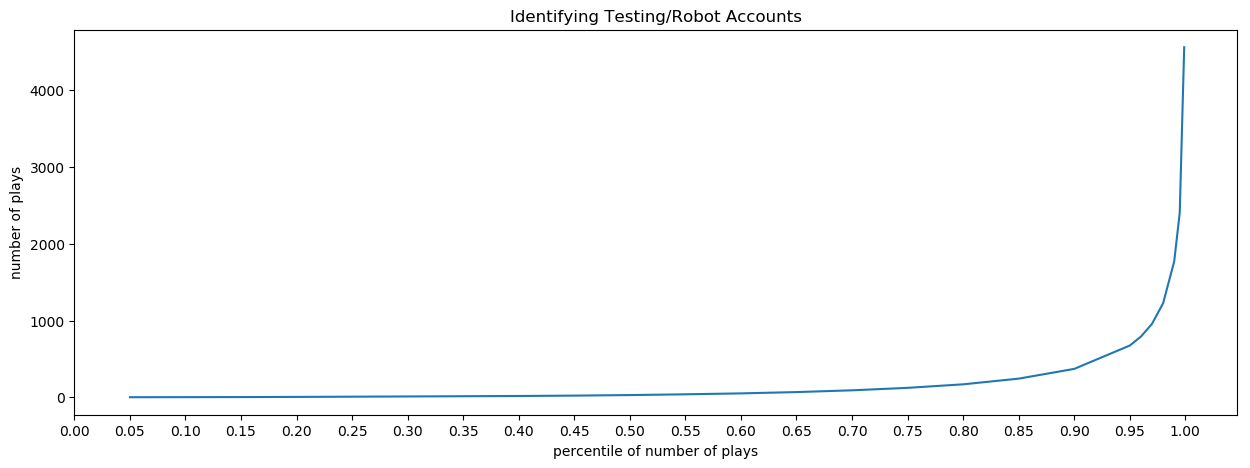

In [35]:
plt.clf()
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(p_df['percentile'], p_df['num_plays'])
ax.set_xlabel('percentile of number of plays')
ax.set_ylabel('number of plays') 
ax.set_xticks(np.arange(0,1.05, 0.05))
ax.set_title('Identifying Testing/Robot Accounts')
plt.show()

In [37]:
# very slow. do not do it again
all_uid_count.repartition(1).write.csv('/Users/cheng/Desktop/musicbox/log/all_uid_count', header=True)

In [41]:
#all_uid_count = spark.read.csv('/Users/cheng/Desktop/musicbox/log/all_uid_count.csv', header=True)

In [42]:
#song_df.select('play_time', 'song_length', 'paid_flag').describe().show()

In [43]:
song_df_2 = song_df.withColumn("device", trim(song_df.device)) \
                               .withColumn('date_str', trim(song_df.file_name.substr(1,9))) \
                               .withColumn('date_string', regexp_replace('date_str', '20170339', '20170329')) \
                               .withColumn("unix_date", unix_timestamp('date_string', 'yyyyMMdd')) \
                               .withColumn("date", from_unixtime('unix_date').cast(DateType())) \
                               .drop('date_str') \
                               .drop('date_string') \
                               .drop('unix_date') \
                               .drop('paid_flag') \
                               .drop('song_name') \
                               .drop('singer') \
                               .dropna(how='any', subset=['play_time'])

In [44]:
pd.DataFrame(song_df_2.take(5), columns=song_df_2.columns)

,uid,device,song_id,song_type,play_time,song_length,file_name,date
0,154824972,ar,3300104.0,0.0,22.0,178.0,20170302_1_play.log,2017-03-02
1,154431666,ar,6651913.0,0.0,252.0,251.0,20170302_1_play.log,2017-03-02
2,154439430,ar,20870988.0,0.0,358.0,358.0,20170302_1_play.log,2017-03-02
3,154739280,ar,872687.0,0.0,164.0,165.0,20170302_1_play.log,2017-03-02
4,154798546,ar,2632638.0,0.0,783.0,0.0,20170302_1_play.log,2017-03-02


In [45]:
song_df_3 = song_df_2.drop('file_name') \
                     .filter(song_df_2.date>='2017-03-31') \
                     .filter(song_df_2.song_length > 0) \
                     .filter(song_df_2.song_length < 10E6) \
                     .filter(song_df_2.play_time >= 0) \
                     .filter(song_df_2.play_time<10E6)

In [46]:
pd.DataFrame(song_df_3.take(5), columns=song_df_3.columns)

,uid,device,song_id,song_type,play_time,song_length,date
0,168029752,ar,1026364.0,0.0,0.0,277.0,2017-03-31
1,168029752,ar,234903.0,0.0,0.0,315.0,2017-03-31
2,167965547,ar,6606144.0,0.0,256.0,256.0,2017-03-31
3,168029752,ar,1026363.0,0.0,0.0,266.0,2017-03-31
4,168029752,ar,234901.0,0.0,245.0,245.0,2017-03-31


In [48]:
# test my hypothesis that song_type is related to play_time recorded in milli-seconds
# song_df_3.sample(False, 0.00001, seed=0) \
         .groupBy('song_type') \
         .agg({'play_time': 'avg', \
               'song_length':'avg' }) \
         .show()

IndentationError: unexpected indent (<ipython-input-48-491fdf3f45d4>, line 3)

In [68]:
song_df_3.sample(False, 0.00001, seed=0).groupBy('song_type').agg({'play_time': "max"}).show()

+---------+--------------+
|song_type|max(play_time)|
+---------+--------------+
|      2.0|          47.0|
|      1.0|      308476.0|
|      0.0|      295695.0|
+---------+--------------+



In [69]:
song_df_4 = song_df_3.withColumn('play_time_adj', \
                                 when(song_df_3.play_time > 10E3, song_df_3.play_time/1000) \
                                 .otherwise(song_df_3.play_time)) \
                     .withColumn('song_length_adj', \
                                 when(song_df_3.song_length > 10E3, song_df_3.song_length/1000) \
                                 .otherwise(song_df_3.song_length))

In [70]:
song_df_4.sample(False, 0.00001, seed=0).groupBy('song_type').agg({'play_time': "max", "uid":"count"}).show()

+---------+----------+--------------+
|song_type|count(uid)|max(play_time)|
+---------+----------+--------------+
|      2.0|         1|          47.0|
|      1.0|        49|      308476.0|
|      0.0|       319|      295695.0|
+---------+----------+--------------+



In [71]:
song_df_5 = song_df_4.drop('play_time') \
                     .drop('song_length') \
                     .withColumnRenamed('play_time_adj', 'play_time') \
                     .withColumnRenamed('song_length_adj', 'song_length')

In [74]:
song_df_5.persist(MEMORY_AND_DISK_SER)

DataFrame[uid: string, device: string, song_id: float, song_type: float, date: date, play_time: double, song_length: double]

In [75]:
song_df_5.schema

StructType(List(StructField(uid,StringType,false),StructField(device,StringType,true),StructField(song_id,FloatType,false),StructField(song_type,FloatType,true),StructField(date,DateType,true),StructField(play_time,DoubleType,true),StructField(song_length,DoubleType,true)))

In [76]:
pd.DataFrame(song_df_5.take(5), columns=song_df_5.columns)

,uid,device,song_id,song_type,date,play_time,song_length
0,168029752,ar,1026364.0,0.0,2017-03-31,0.0,277.0
1,168029752,ar,234903.0,0.0,2017-03-31,0.0,315.0
2,167965547,ar,6606144.0,0.0,2017-03-31,256.0,256.0
3,168029752,ar,1026363.0,0.0,2017-03-31,0.0,266.0
4,168029752,ar,234901.0,0.0,2017-03-31,245.0,245.0


In [77]:
# Results from previous sanity check. Takes too long to run... 
song_df.select('play_time', 'song_length', 'paid_flag').describe().show()

+-------+--------------+-------------------+---------+
|summary|     play_time|        song_length|paid_flag|
+-------+--------------+-------------------+---------+
|  count|      63274608|           63274608| 63274608|
|   mean|           NaN|-183.79767182414633|      0.0|
| stddev|           NaN|  962704.0810031396|      0.0|
|    min|-1.02297313E11|      -2.14748365E9|      0.0|
|    max|           NaN|       3.99313856E8|      0.0|
+-------+--------------+-------------------+---------+



In [78]:
# calculate percentile in spark is very slow. Much faster in excel...# calcu 
# count_ceiling = uid_count.approxQuantile("count", [0.95], 0)

In [103]:
valid_uid = all_uid_count.filter(all_uid_count['count'] <= 2406)

In [110]:
valid_uid.repartition(1).write.csv('/Users/cheng/Desktop/musicbox/log/valid_uic.csv')
# in case session is terminated, to save time, just read from csv to load the DataFrame

In [111]:
valid_uid.count()

744014

In [112]:
valid_uid.dtypes

[('uid', 'string'), ('count', 'bigint')]

In [ ]:
active_uid = spark.read.csv('active_uid.csv')
# valid_uid = spark.read.csv('/Users/cheng/Desktop/musicbox/log/valid_uid.csv')

In [91]:
valid_uid

DataFrame[uid: string, count: int]

In [92]:
valid_uid.schema

StructType(List(StructField(uid,StringType,true),StructField(count,IntegerType,true)))

In [93]:
song_df_valid = song_df_5.join(valid_uid, song_df_5.uid == valid_uid.uid, how='inner') \
                         .drop(song_df_5.uid) \
                         .persist(storageLevel=MEMORY_AND_DISK_SER)

In [86]:
pd.DataFrame(song_df_valid.take(5), columns=song_df_valid.columns)

,device,song_id,song_type,date,play_time,song_length,uid,count
0,ar,23497506.0,0.0,2017-03-31,32.0,365.0,104777734,3
1,ar,23498554.0,0.0,2017-03-31,3.0,230.0,104777734,3
2,ar,23489300.0,0.0,2017-03-31,2.0,181.0,104777734,3
3,ar,6105666.0,0.0,2017-04-02,136.0,153.0,11596711,17
4,ar,147466.0,0.0,2017-04-02,41.0,270.0,11596711,17
